## Project Setup

In [ ]:
# install needed libraries
!pip install pyarrow
!pip install fastparquet
!pip install geopandas
!pip install pytest
!pip install keplergl
!pip install bs4

In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import sqlite3
import numpy as np
import matplotlib.animation as animation
import keplergl
from keplergl import KeplerGl
import statistics
import unittest

In [46]:
# add constant
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
taxi_data = pd.read_csv(r"C:\Users\Silvia\Documents\GitHub\Projects-portfolio\Uber_and_Yellow_Taxi\taxi_sample.csv",index_col='Unnamed: 0')
uber_data = pd.read_csv(r"C:\Users\Silvia\Documents\GitHub\Projects-portfolio\Uber_and_Yellow_Taxi\uber_data.csv",index_col='Unnamed: 0')
engine = db.create_engine(DATABASE_URL)
shapefile = gpd.read_file(r"C:\Users\Silvia\Documents\GitHub\4501FinalProject_Group14\taxi_zones\taxi_zones.shp")
shapefile = shapefile.to_crs(4326)
shapefile['latitude'] = shapefile['geometry'].centroid.y
shapefile['longitude'] = shapefile['geometry'].centroid.x

C:\Users\Silvia\AppData\Local\Temp\ipykernel_12188\3820586680.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['latitude'] = shapefile['geometry'].centroid.y
C:\Users\Silvia\AppData\Local\Temp\ipykernel_12188\3820586680.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['longitude'] = shapefile['geometry'].centroid.x


## Visualization 1

_**TODO:** Plot the number of taxi trips per hour of the day._

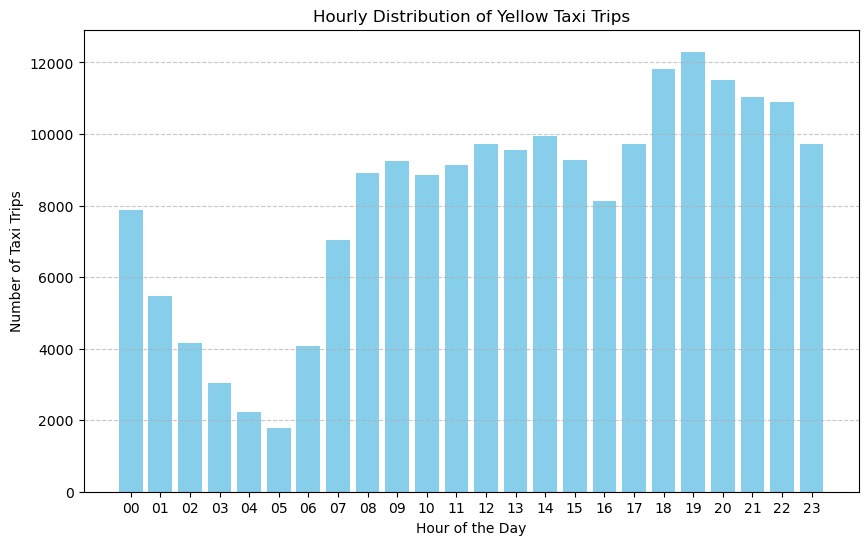

In [20]:
QUERY_4_1 = """
SELECT strftime ('%H',pickup_datetime) AS HOUR,
COUNT(strftime ('%H',pickup_datetime)) AS NUMBERS
FROM taxi_trips
GROUP BY HOUR
"""

def get_data_for_visual_1():
    df = pd.read_sql(QUERY_4_1, con = engine)
    return df

def plot_visual_1(dataframe):
    plt.figure(figsize=(10, 6))
    plt.bar(dataframe['HOUR'], dataframe['NUMBERS'], color='skyblue')
    plt.title('Hourly Distribution of Yellow Taxi Trips')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Taxi Trips')
    plt.xticks(range(24))  # Show all hours on x-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

df = get_data_for_visual_1()
plot_visual_1(df)

## Visualization 2

_**TODO:** Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization._

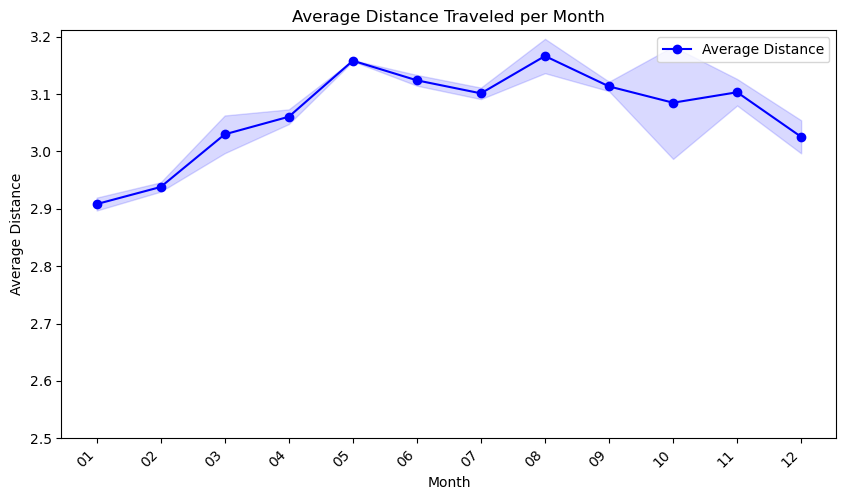

In [24]:
QUERY_4_2 = """
SELECT month,
       total_trips,
       AVG(avr_distance) as average_distance,
       (count(distance)*sum(distance*distance) - (sum(distance)*sum(distance))) / ((count(distance)-1)*(count(distance))) as variance
FROM 
    (SELECT 
        trip_distance AS distance,
        strftime ('%m',pickup_datetime) AS month,
        count(*) AS total_trips,
        AVG(trip_distance) AS avr_distance
    FROM 
        taxi_trips
    GROUP BY 
        strftime ('%m',pickup_datetime)
    UNION 
    SELECT 
        trip_distance AS distance,
        strftime ('%m',pickup_datetime) AS month,
        count(*) AS total_trips,
        AVG(trip_distance) AS avr_distance
    FROM 
        uber_trips
    GROUP BY 
        strftime ('%m',pickup_datetime)
    ) trips
GROUP BY
    trips.month
"""

def get_data_for_visual_2():
    df = pd.read_sql(QUERY_4_2, con=engine)
    return df

# Get data
df = get_data_for_visual_2()

# Calculate confidence intervals
ci_lower = df['average_distance'] - 1.64 * np.sqrt(df['variance']) / np.sqrt(df['total_trips'])
ci_upper = df['average_distance'] + 1.64 * np.sqrt(df['variance']) / np.sqrt(df['total_trips'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = df['month']
ax.plot(x, df['average_distance'], marker='o', color='b', label='Average Distance')
ax.fill_between(x, ci_lower, ci_upper, color='b', alpha=0.15)
ax.set_ylim(ymin=2.5)
ax.set_title('Average Distance Traveled per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Distance')
ax.legend()
fig.autofmt_xdate(rotation=45)
plt.show()

## Visualization 3

_**TODO:** Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport._

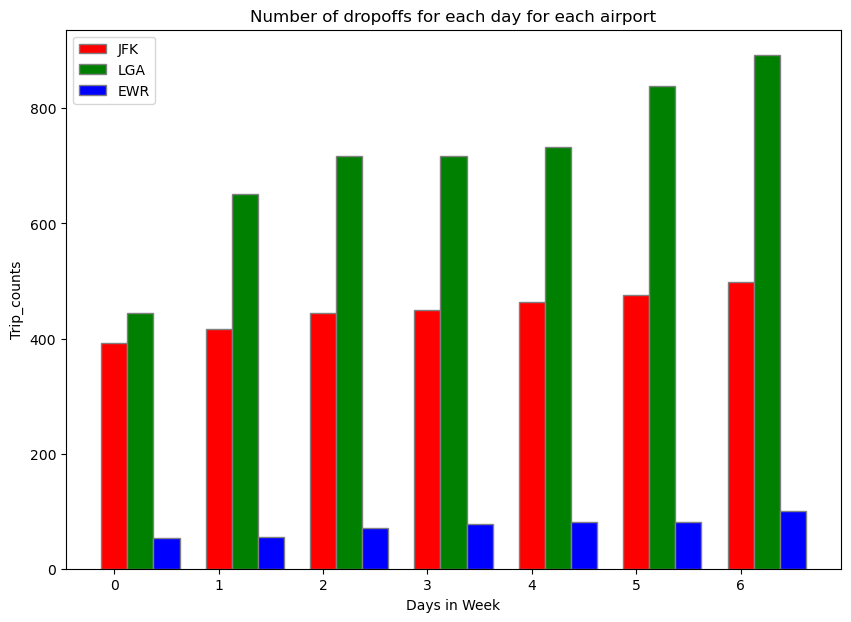

In [30]:
JFK_BOX = [-73.825248, 40.620479, -73.746971, 40.666458]
LGA_BOX = [-73.890716,40.767245,-73.854667,40.781415]
EWR_BOX = [-74.192324,40.670659,-74.153185, 40.708601]

def plot_visual_3():
    query_JFK = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.825248 AND -73.746971 AND dropoff_latitude BETWEEN 40.620479 AND 40.666458
    GROUP BY day
    ORDER BY Trip_counts
    """
    query_LGA = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.890716 AND -73.854667 AND dropoff_latitude BETWEEN 40.767245 AND 40.781415
    GROUP BY day
    ORDER BY Trip_counts
    """

    query_EWR = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -74.192324 AND -74.153185 AND dropoff_latitude BETWEEN 40.670659 AND 40.708601
    GROUP BY day
    ORDER BY Trip_counts
    """

    df_JFK = pd.read_sql(query_JFK, con = engine)
    df_LGA = pd.read_sql(query_LGA, con = engine)
    df_EWR = pd.read_sql(query_EWR, con = engine)
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(10, 7))
    br1 = np.arange(len(df_JFK['day']))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    plt.bar(br1, df_JFK['Trip_counts'], color ='r', width = barWidth,
            edgecolor ='grey', label ='JFK')
    plt.bar(br2, df_LGA['Trip_counts'], color ='g', width = barWidth,
            edgecolor ='grey', label ='LGA')
    plt.bar(br3, df_EWR['Trip_counts'], color ='b', width = barWidth,
            edgecolor ='grey', label ='EWR')

    plt.title('Number of dropoffs for each day for each airport')
    plt.xlabel('Days in Week')
    plt.ylabel('Trip_counts')

    plt.legend()
    plt.show()

plot_visual_3()

## Visualization 4

_**TODO:** Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations._

In [33]:
get_map = KeplerGl(height = 500)
get_map.add_data(uber_data, name = "heatmap")
get_map.add_data(taxi_data, name = "heatmap")
get_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'heatmap': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

## Visualization 5

_**TODO:** Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit._

In [55]:
def plot_visual_5():
    query_visual_5 = """
    SELECT tip_amount, trip_distance FROM taxi_trips
    """

    df_tip_distance = pd.read_sql(query_visual_5, con = engine)
    plt.scatter(x = df_tip_distance['tip_amount'], y = df_tip_distance['trip_distance'])
    plt.xlabel('tip_amount') 
    plt.ylabel('trip_distance') 
    plt.title('tip_amount vs. trip_distance')
    plt.show()

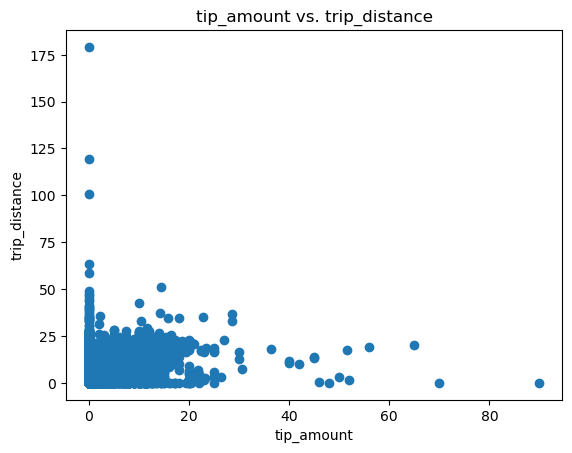

In [56]:
plot_visual_5()

## Visualization 6

_**TODO:** Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit._

In [57]:
def plot_visual_6():
    query_taxi ="""SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, tip_amount
            FROM taxi_trips
            """ 
    query_weather ="""SELECT strftime('%Y-%m-%d %H', DATE) AS DATE, HourlyPrecipitation
            FROM hourly_weathers
            """

    taxi_data = pd.read_sql_query(query_taxi, con = engine)
    weather_data = pd.read_sql_query(query_weather, con = engine)
    
    taxi_data['DATE'] = pd.to_datetime(taxi_data['DATE'], format='%Y-%m-%d %H')
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'], format='%Y-%m-%d %H')

    df = pd.merge(taxi_data, weather_data, on='DATE')
    df = df[(df['HourlyPrecipitation'] > 0) & (df['tip_amount'] < 50)]
    
    # sample the data to make the scatter plot clearer
    df.plot(x="HourlyPrecipitation", y="tip_amount", kind="scatter", title="tip_amount vs. Precipitation")

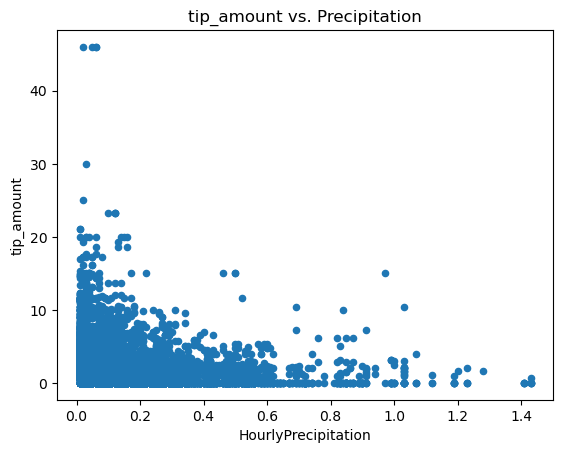

In [58]:
plot_visual_6()

## Visualization 8

_**TODO:** Create animation of our visualization 1_


C:\Users\Silvia\AppData\Local\Temp\ipykernel_12188\692739761.py:35: UserWarning: frames=<function generate_data at 0x0000020DD2745EA0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation.FuncAnimation(fig, update, generate_data, interval=23,


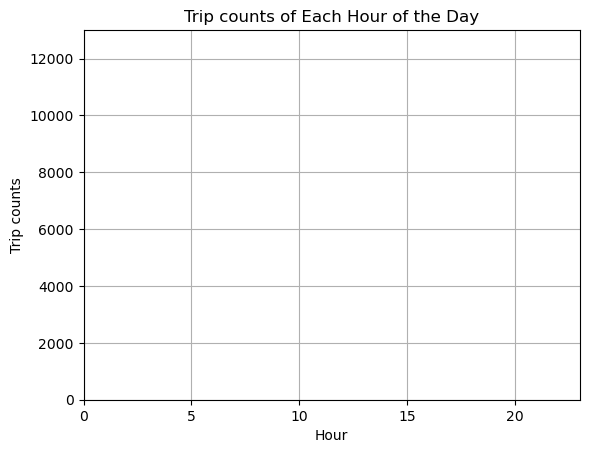

In [61]:
df = pd.read_sql_query(QUERY_1, engine).sort_values(by="HOUR", ascending=True)
df.index = df['HOUR']

def generate_data():
    for i in range(24):
        yield int(df['HOUR'][i]), int(df['Trip_counts'][i])

# initialize the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
x_data = []
y_data = []

# create a function that initializes the plot
def initialization():
    ax.set_ylim(0, 13000)
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Trip counts')
    ax.set_title('Trip counts of Each Hour of the Day')
    del x_data[:]
    del y_data[:]
    line.set_data(x_data, y_data)
    return line

# create a function that updates the data of each hour
def update(data: tuple):
    x, y = data
    x_data.append(x)
    y_data.append(y)
    line.set_data(x_data, y_data)
    return line

animation.FuncAnimation(fig, update, generate_data, interval=23,
                            repeat=False, init_func=initialization)

## Visualization 8

_**TODO:** What is the average tip amount of yellow taxi trips at day(during the time between sunrise and sunset) and at night(during the time between sunset and sunrise)?_

In [62]:
def plot_visual_sunrise_sunset():
    query_tip_amount = """
    SELECT date(pickup_datetime) AS DATE, pickup_datetime, tip_amount FROM taxi_trips
    """
    query_sun = """
    SELECT date(DATE) AS DATE, Sunrise, Sunset FROM sunrise_sunsets
    """

    tip_df = pd.read_sql_query(query_tip_amount, con = engine)
    sunrise_sunset_df = pd.read_sql_query(query_sun, con = engine)

    # convert the date to datetime
    tip_df['DATE'] = pd.to_datetime(tip_df['DATE'], format='%Y-%m-%d')
    tip_df['pickup_datetime']=[i.replace('UTC','') for i in tip_df['pickup_datetime']]
    tip_df['pickup_datetime'] = pd.to_datetime(tip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    sunrise_sunset_df['DATE'] = pd.to_datetime(sunrise_sunset_df['DATE'], format='%Y-%m-%d')

    # merge the two dataframes
    df = pd.merge(tip_df, sunrise_sunset_df, on='DATE')    

    # calculate the minutes using hour and minute
    df['Sunrise_minutes'] = df['Sunrise'].map(lambda x: int(str(x)[0]) * 60 + int(str(x)[1:]))
    df['Sunset_minutes'] = df['Sunset'].map(lambda x: int(str(x)[:2]) * 60 + int(str(x)[2:]))
    df['pickup_datetime_minutes'] = df['pickup_datetime'].map(lambda x: x.hour * 60 + x.minute)

    # find the trips that started during the day
    df['day'] = (df['pickup_datetime_minutes'] > df['Sunrise_minutes']) & (df['pickup_datetime_minutes'] < df['Sunset_minutes'])

    # Calculate the average tip amount during day and night
    tip_amount_day = []
    tip_amount_night = []
    for i in range(len(df.index)):
        if df['day'][i] == True:
            tip_amount_day.append(df["tip_amount"][i])
        else:
            tip_amount_night.append(df["tip_amount"][i])

    average_tip_day = statistics.mean(tip_amount_day)
    average_tip_night = statistics.mean(tip_amount_night)
    #plot a bar chart with average tip in day compared to in night
    plt.bar(['average_tip_day', 'average_tip_night'], [average_tip_day, average_tip_night], color ='maroon')
    plt.title('Average tip amount at day and at night')

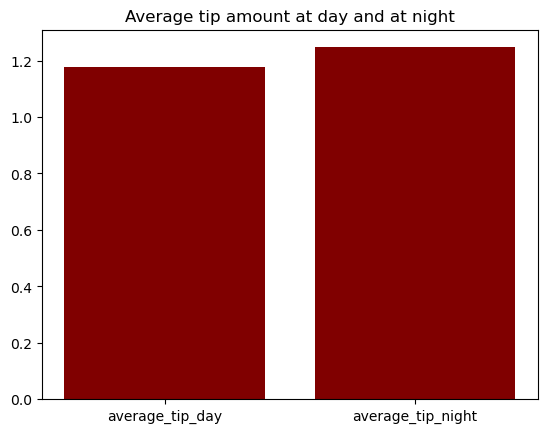

In [63]:
plot_visual_sunrise_sunset()